### 2021 Canadian Federal Election - IRV Ranked Choice Voting Simulation 

In [1]:
import pandas as pd
df = pd.read_csv("combined_voting_data_final.csv")

In [2]:
df_header = df.rename(columns={'Electoral.District.Number.Numéro.de.circonscription': 'Riding_number', 'Electoral.District.Name.Nom.de.circonscription':'Riding_name'})

In [ ]:
df_header.loc[df_header['Riding_number'] == 24002, 'Conservative Party of Canada'] = 5339
df_clean = df_header.fillna(0)
df_clean['Riding_number'] = df_clean['Riding_number'].astype(str)
df_clean.head()

df_inter = df_clean
df_inter['GroupKey'] = df_inter['Riding_number'].str[:2]

df_unstrat = (
    df_inter.groupby('GroupKey')
      .agg({col: 'sum' for col in df_inter.columns[2:8]}  
           | {'Riding_number': 'count'})                     
      .rename(columns={'Riding_number': 'Ridings'})         
      .reset_index()
)

,GroupKey,Conservative Party of Canada,New Democratic Party,Liberal Party of Canada,People's Party of Canada,Green Party of Canada,Bloc Québécois,Ridings
0,10,70783.0,37743.0,104240.0,5150.0,0.0,0.0,7
1,11,26673.0,7802.0,39046.0,2748.0,8048.0,0.0,4
2,12,144315.0,87485.0,207237.0,19365.0,8902.0,0.0,11
3,13,115369.0,47353.0,168945.0,24346.0,20162.0,0.0,10
4,24,756412.0,383953.0,1310820.0,103835.0,61488.0,1256606.0,78
5,35,2215895.0,1134710.0,2535222.0,344058.0,138215.0,0.0,121
6,46,224682.0,131591.0,155314.0,43519.0,8107.0,0.0,14
7,47,304698.0,108720.0,54731.0,32301.0,5699.0,0.0,14
8,48,1075638.0,358291.0,299493.0,142479.0,17483.0,0.0,34
9,59,750394.0,656325.0,608588.0,108580.0,118329.0,0.0,42


In [ ]:
import numpy as np
import pandas as pd
from instant_runoff import run_instant_runoff
from instant_runoff import redistribute_votes_integer

# Party orderings
QUEBEC_PARTIES = ['Conservative Party of Canada', 'Liberal Party of Canada', 'New Democratic Party', 'Bloc Québécois', 'Green Party of Canada', 'People\'s Party of Canada']
CANADA_PARTIES = ['Conservative Party of Canada', 'Liberal Party of Canada', 'New Democratic Party', 'Green Party of Canada', 'People\'s Party of Canada']

# Ranking matrices (alphas for Dirichlet)
Q_matrix = [
    [0, 0.118578397, 0.177867596, 0.654146341, 0.024703833, 0.024703833],
    [0.205117808, 0, 0.555024658, 0.1192, 0.096526027, 0.024131507],
    [0.146531532, 0.476227477, 0, 0.120810811, 0.219797297, 0.036632883],
    [0.418181818, 0.363636364, 0.181818182, 0, 0.018181818, 0.018181818],
    [0.08, 0.3, 0.45, 0.15, 0, 0.02],
    [0.7, 0.05, 0.04, 0.2, 0.01, 0]
]

C_matrix = [
    [0, 0.342857143, 0.514285714, 0.071428571, 0.071428571],
    [0.232876712, 0, 0.630136986, 0.109589041, 0.02739726],
    [0.166666667, 0.541666667, 0, 0.25, 0.041666667],
    [0.1, 0.35, 0.51, 0, 0.04],
    [0.82, 0.1, 0.05, 0.03, 0]
]
 
def simulate_election(df, strat):
    results = []
    for i, row in df.iterrows():
        if strat == False:
            if row["GroupKey"].startswith("24"):
                winner = run_instant_runoff(row, Q_matrix, QUEBEC_PARTIES)
            else:
                winner = run_instant_runoff(row, C_matrix, CANADA_PARTIES)
        else:
            if row["Riding_number"].startswith("24"):
                winner = run_instant_runoff(row, Q_matrix, QUEBEC_PARTIES)
            else:
                winner = run_instant_runoff(row, C_matrix, CANADA_PARTIES)
        results.append(winner)
    df['IRV_winner'] = results
    return df

In [ ]:
## Stratified

lib_seats = []
con_seats = []
bloc_seats = []
ndp_seats = []
green_seats = []
ppc_seats = []
for i in range(500):
    df_final = simulate_election(df_clean, True)
    lib_seats.append(int(df_final["IRV_winner"].value_counts().iloc[0]))
    con_seats.append(int(df_final["IRV_winner"].value_counts().iloc[1]))
    bloc_seats.append(int(df_final["IRV_winner"].value_counts().iloc[2]))
    ndp_seats.append(int(df_final["IRV_winner"].value_counts().iloc[3]))
    if (len(df_final["IRV_winner"].value_counts()) < 5):
        green_seats.append(0)
    else:
        green_seats.append(int(df_final["IRV_winner"].value_counts().iloc[4]))
    ppc_seats.append(0)


In [40]:
## Unstratified

lib_seats = []
con_seats = []
bloc_seats = []
ndp_seats = []
green_seats = []
ppc_seats = []
for i in range(500):
    df_final = simulate_election(df_unstrat, False)
    result =df_final.groupby('IRV_winner', as_index=True)['Ridings'].sum()
    lib_seats.append(int(result.loc['Liberal Party of Canada']))
    con_seats.append(int(result.loc['Conservative Party of Canada']))
    if ('Bloc Québécois' in result.index):
        bloc_seats.append(int(result.loc['Bloc Québécois']))
    else:
        bloc_seats.append(0)

    if ('New Democratic Party' in result.index):
        ndp_seats.append(int(result.loc['New Democratic Party']))
    else:
        ndp_seats.append(0)

    if ('Green Party of Canada' in result.index):
        green_seats.append(int(result.loc['Green Party of Canada']))
    else:
        green_seats.append(0)
    ppc_seats.append(0)

In [41]:
import matplotlib.pyplot as plt

def generate_histograms_from_lists(conservative, ndp, liberal, ppc, green, bloc) -> None:
    """
    Generate histograms for each party's seat distribution across simulations using input lists.
    
    Args:
        conservative, ndp, liberal, ppc, green, bloc: Lists of seat counts from simulations
    """
    print("\n=== GENERATING HISTOGRAMS ===")
    
    parties = ["Conservative", "NDP", "Liberal", "PPC", "Green", "Bloc"]
    party_data = [conservative, ndp, liberal, ppc, green, bloc]
    colors = {
        "Conservative": "blue",
        "NDP": "orange", 
        "Liberal": "red",
        "PPC": "purple",
        "Green": "green",
        "Bloc": "cyan"
    }

    # Combined subplot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Seat Distribution Histograms by Party', fontsize=16)
    
    for idx, (party, data) in enumerate(zip(parties, party_data)):
        if not data:
            continue

        mean_seats = sum(data) / len(data)
        std_dev = (sum((s - mean_seats) ** 2 for s in data) / len(data)) ** 0.5
        coeff_var = std_dev / mean_seats if mean_seats != 0 else 0
        
        row, col = divmod(idx, 3)
        ax = axes[row, col]

        bins = range(min(data), max(data) + 2) if max(data) > min(data) else [min(data) - 0.5, min(data) + 0.5]

        ax.hist(data, bins=bins, edgecolor='black', color=colors[party], alpha=0.7, align='left')
        ax.axvline(mean_seats, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_seats:.1f}')
        
        ax.set_xlabel(f'{party} Seats')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{party} Seat Distribution\n(μ={mean_seats:.1f}, cv={coeff_var:.2f})')
        ax.legend()
        ax.grid(True, alpha=0.3)

        stats_text = f'Mean: {mean_seats:.1f}\ncoeff_var: {coeff_var:.2f}\nRange: {min(data)}–{max(data)}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

    # Individual histograms
    print("\nGenerating individual party histograms...")
    for party, data in zip(parties, party_data):
        if not data:
            continue

        mean_seats = sum(data) / len(data)
        std_dev = (sum((s - mean_seats) ** 2 for s in data) / len(data)) ** 0.5
        coeff_var = std_dev / mean_seats if mean_seats != 0 else 0
        bins = range(min(data), max(data) + 2) if max(data) > min(data) else [min(data) - 0.5, min(data) + 0.5]

        plt.figure(figsize=(8, 6))
        plt.hist(data, bins=bins, edgecolor='black', color=colors[party], alpha=0.7, align='left')
        plt.axvline(mean_seats, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_seats:.1f}')
        
        plt.xlabel(f'{party} Seats')
        plt.ylabel('Frequency')
        plt.title(f'Variance of {party} Seats\n(μ={mean_seats:.1f}, cv={coeff_var:.2f})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


=== GENERATING HISTOGRAMS ===


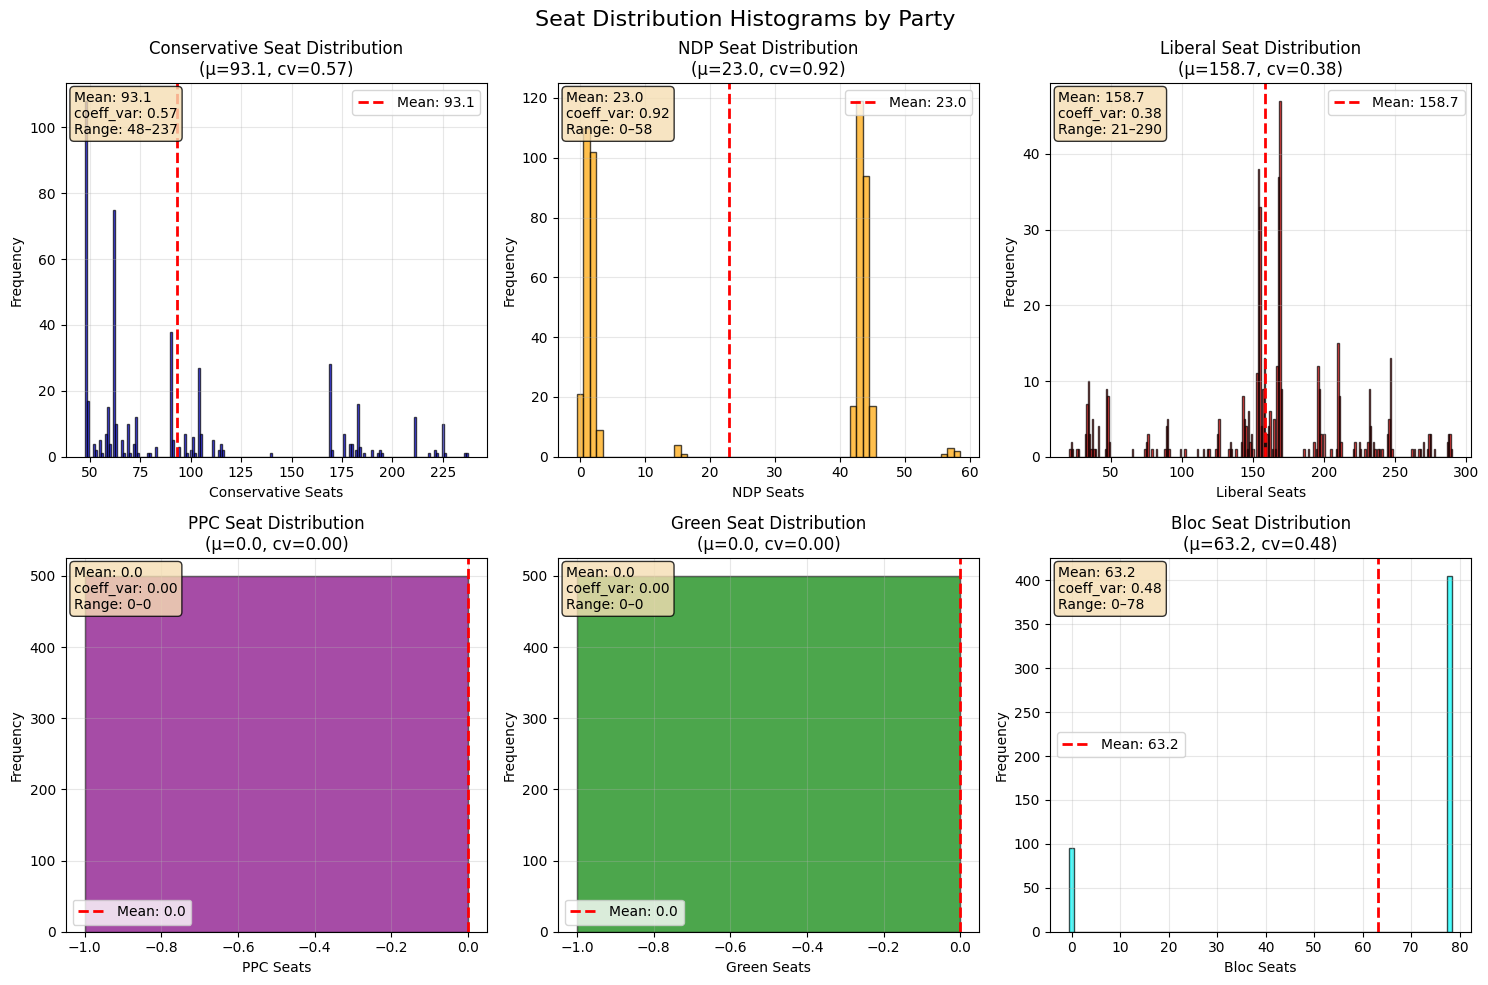


Generating individual party histograms...


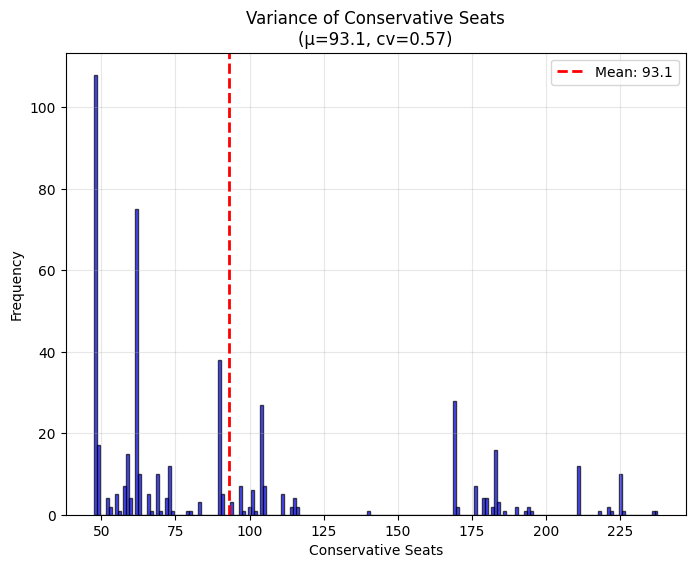

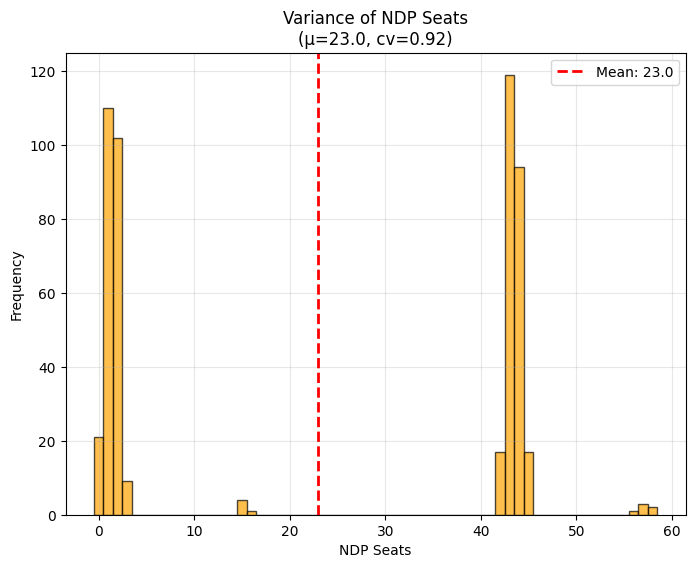

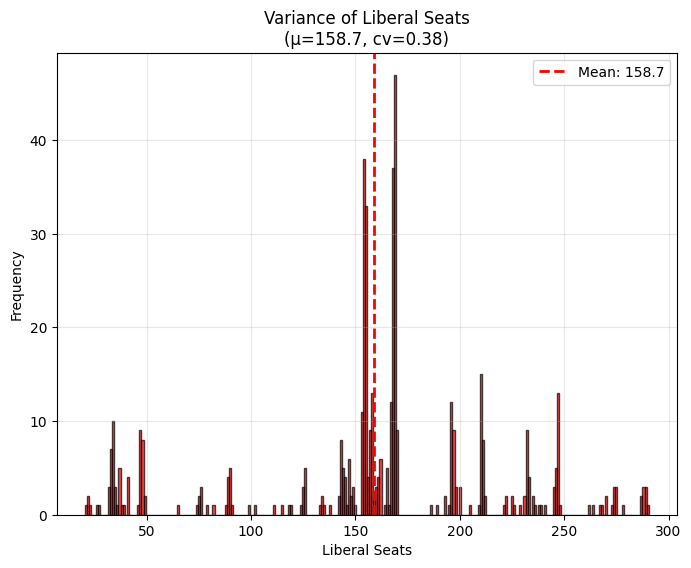

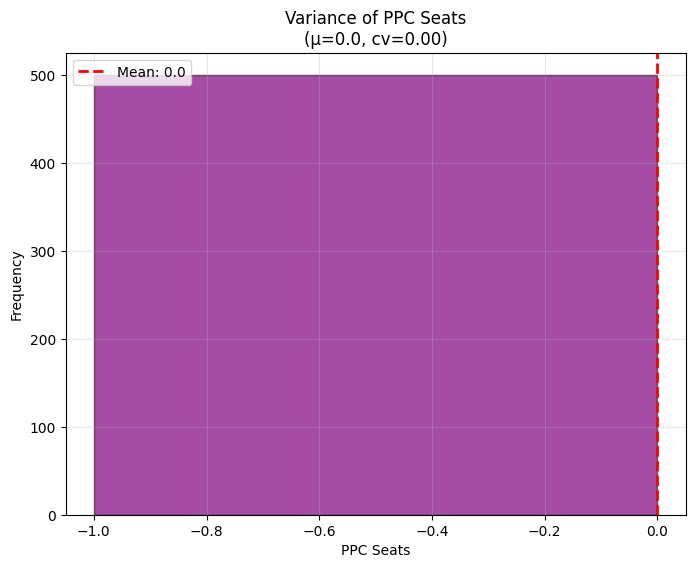

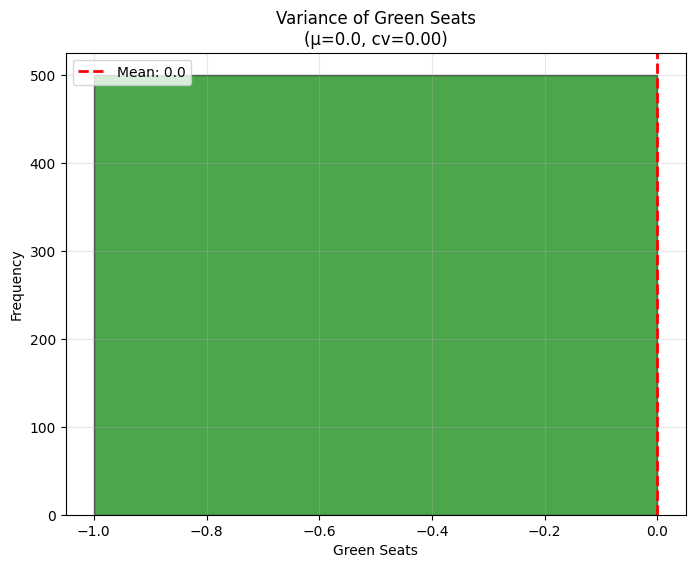

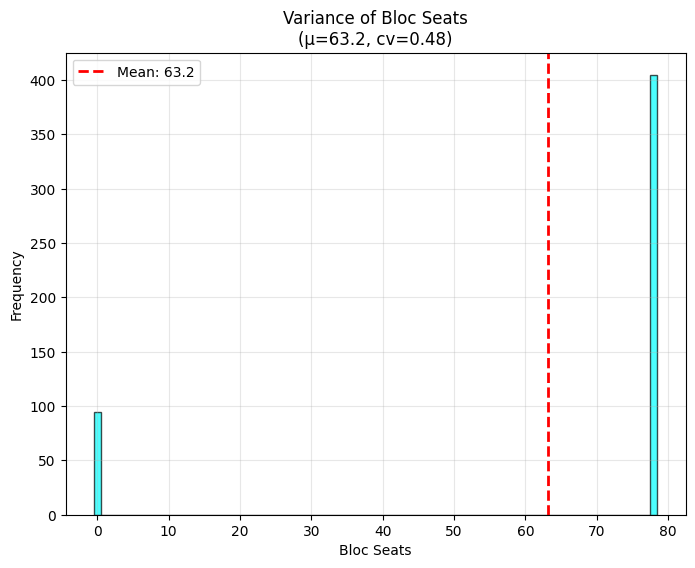

In [42]:
generate_histograms_from_lists(con_seats, ndp_seats, lib_seats, ppc_seats, green_seats, bloc_seats)